## IQFT Segmentation Algorithm ##

**Purpose:** The goal of this algorithm is to extract areas of interest from an image, while leaving other aspects in the background. We theorize that this algorithm could decrease image post-processing time and increase image segmentation accuracy.

**Quantum Challenge:** Currently, the program uses matrices instead of qubits. We would like to move to using logical qubits, then hardware qubits. IQFT segmentation qubit requirements only depend on the number of possible classes we request. In most cases, the algorithm will only require <10 qubits. However, using more CNOT gates could quickly increase circuit depth.

**Accuracy Quantification:** IQFT preformance is compared to K-Means Clustering and Multi-Otsu Thresholding segmentation algorithms. IQFT has proven to outperform these classical algorithms with segmenting RGB images using mOUI scoring metrics. The Xiaojuan Li lab (BME) used Dice Scoring to quantify how well only areas of interest were extracted while other ascpects were left in the background.

**Image Types:** The Xiaojuan Li lab (BME) has upgraded IQFT to segment 3D MRIs (grey-scale). For Air Force applications, satellite images (RGB) will be used for object segmentation.

**Paper Link:** https://arxiv.org/pdf/2301.04705.pdf

## Import Necessary Libraries ##

In [88]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path as op
import os
from PIL import Image

## The IQFT Segmentation Function ##

**Input:** The function takes an image, a number of qubits, a theta-value, a max. pixel value, and a min. pixel value. Theta is a factor to convert a pixel value to a qubit phase value. &theta; &isin; [0, 2&pi;]

**Work Flow:**
1. Load RGB or grey-scale image and convert to an array.
2. Normalize pixel values.
3. For RGB, multiply 8x8 W-matrix w/ "input vector" to get the 8x1 probability amplitude matrix. W-matrix is a bit of a black-box, but matrix entries are easily determined. Input vector is the conversion of RGB values to qubit phase values. Probability amplitude matrix determines the pixel's probability amplitude to be classified in on of the 8 quantum states. The state with the largest probability amplitude is the classification of the pixel. For grey-scale, a 2x2 W-matrix is multiplied w/ the input vector to get a 2x1 probability amplitude matrix.
4. Apply step 3 to each pixel and map classifications onto a 2D array.
5. Calculate Dice Score of the IQFT mask based on a "ground truth" image

**Output:** The function returns the Dice Scores for the IQFT mask accuracy when compared to the desired ground truth file

**Paper Link:** https://arxiv.org/pdf/2301.04705.pdf

In [89]:
def iqft_mask(img_py, nqubits=3, theta=2*np.pi, imin=0, imax=255):
    
    # code for iqft of a single 2d image goes here
    def im2arr(file_path):
    # load grayscale image
        img = Image.open(file_path).convert("L") #convert to grayscale; use "RGB" for RGB
        return np.array(img)

    def img2ang(image, imax=255, imin=0):
        if imax is None: imax = np.max(image)
        tmp = ((image - imin) / (imax - imin)) * 255
        out = tmp / 255.
        return out

    def ang2basis(angles, nqubits = 3, theta=27*np.pi/40, transform=1):
        N = 2 ** nqubits
        w = np.exp((1j * 2 * np.pi) / N) # = 1/N
        _wp = lambda x: w ** (x)
        _fgray = lambda g : np.array([1, np.exp(g*1j)]) #qubit phase values (F_m)
        _wgray = np.array([[1, 1], [1, -1]]) #"Complex" W matrix for grey scale

        _frgb = lambda g,b,a : np.array([1, np.exp(g*1j), np.exp(b*1j), np.exp(1j*(b+g)), np.exp(1j*a), np.exp(1j*(a+g)), np.exp(1j*(a+b)), np.exp(1j*(a+b+g))])
        # _wrgb = 1./np.sqrt(N) * np.array([np.array([_wp(i) for i in range(N)])**(-j) for j in range(N)]).T     # Using fourier transform expansion
        _wrgb = np.array([[         1,    1,       1,        1,      1,       1,       1,       1], # Explain purpose of each w value: Define expansion explicitly
                                [1, _wp(-1), _wp(-2), _wp(-3), _wp(-4), _wp(-5), _wp(-6), _wp(-7)],
                                [1, _wp(-2), _wp(-4), _wp(-6),    1,    _wp(-2), _wp(-4), _wp(-6)],
                                [1, _wp(-3), _wp(-6), _wp(-1), _wp(-4), _wp(-7), _wp(-2), _wp(-5)],
                                [1, _wp(-4),    1,    _wp(-4),    1,    _wp(-4),     1  , _wp(-4)],
                                [1, _wp(-5), _wp(-2), _wp(-7), _wp(-4), _wp(-1), _wp(-6), _wp(-3)],
                                [1, _wp(-6), _wp(-4), _wp(-2),    1,    _wp(-6), _wp(-4), _wp(-2)],
                                [1, _wp(-7), _wp(-6), _wp(-5), _wp(-4), _wp(-3), _wp(-2), _wp(-1)],
        ])

        if (angles.ndim == 2) and transform:
            #angles = np.stack([angles,angles/255,angles/(255*255)],axis=2)
            angles = np.stack([angles,angles,angles],axis=2)

        if angles.ndim == 2:
            _f = _fgray
            W = _wgray
            N = 2 ** 1 #uses 1 qubit by default for grey-scale
        elif angles.ndim == 3:
            if angles.shape[2] == 1:
                angles = np.squeeze(angles)
                _f = _fgray
                W = _wgray
            elif angles.shape[2] == 3:
                _f = _frgb
                W = _wrgb

        nrow, ncol = angles.shape[:2]

        mask = np.zeros((nrow, ncol), dtype='ubyte')

        for i in range(nrow):
            for j in range(ncol):
                if angles.ndim < 3:
                    Fm = _f(angles[i,j,] * theta)     # vector
                else:
                    Fm = _f(*angles[i,j,] * theta)     # vector
                Sm = np.power( np.abs( np.dot(W, Fm) / N ), 2 )   # vector
                lm = np.argmax(Sm) + 1
                mask[i, j] = lm
        return mask

    img_ang = img2ang(img_py, imin=imin, imax=imax)
    img_seg = ang2basis(img_ang, nqubits, theta)
    return img_seg

EPS = np.finfo('float32').eps
def dice(pred, true, eps=EPS):
    ''' Returns dice coeffient given the predicted and true labels

        >>> pred = (segmentation_mask == 1)
        >>> true = (groundtruth_mask == 1)
        >>> dice_score = dice(pred, true)
    '''
    intersection = np.sum( pred.flatten() * true.flatten() )
    dice_score =  (2. * intersection + eps) / ( np.sum(true) + np.sum(pred) + eps)
    return dice_score


## Applying IQFT Seg to an MRI ##

**Image Type:** MRIs use Nifti1 images, so the algorithm was adapted to segment this data type

**Input:** The function takes a "ground truth" image file, the IQFT mask, a number of qubits, and a range of thetas. The origin of the file is determined, ..., and the color mapping is chosen with a string input.

**Work Flow:**
1. Get the ground truth and IQFT mask data
2. Execute IQFT seg. on a range of MRI slices (3D -> 2D)
3. Plot OG slice, OG slice w/ ground truth, the IQFT mask, IQFT mask and ground truth points that overlap, and the difference between IQFT Mask and the ground truth

**Output:** The function returns the Dice Scores for the IQFT mask accuracy when compared to the desired ground truth file

In [90]:
def run_nii(img_file, mask_file, nqubits, thetas, origin='lower', axis=0, cmap='jet'):
    plt.close('all')
    
    nimg = nib.load(img_file)
    mimg = nib.load(mask_file)

    img3d = nimg.get_fdata()
    mask3d_gt = mimg.get_fdata()
    
    nslices = img3d.shape[axis]

    fname, ext = op.splitext(img_file)
    if ".gz" in ext:
        fname, _ext = op.splitext(fname)
        ext = f"{_ext}{ext}"

    dice_scores = np.ndarray((1,2))

    # analyze result for each theta
    for t, theta in enumerate(thetas):
        # placeholder for output mask to compare against groundtruth mask
        mask = np.zeros(img3d.shape, dtype='ubyte')

        # run segmentation for each sagittal slice of 3d image
        for slc in [100]:
            idx = [slice(None)] * 3      
            idx[axis] = slc                      # set slice index
            img_py = img3d[tuple(idx)]           # 2D image slice

            img_py_max = img_py.max()
            img_py_min = img_py.min()

            # max(img_py) not 255 so divide by max intensity of img3d before coverting to angles

            mask2d_gt = mask3d_gt[tuple(idx)] == 1  # 2D mask slice

            # display reference image
            fig, ax = plt.subplots(1,2)
            ren1 = ax[0].imshow(np.rot90(img_py), cmap='gray', label='orig', origin=origin)
            ax[0].axis('off')            
            ax[0].title.set_text('img')            

            # remove extra white space on subplot
            divider = make_axes_locatable(ax[0])
            cax = divider.append_axes('right', size="5%", pad="2%")
            clb = plt.colorbar(ren1, orientation='vertical', shrink=1.0, cax=cax)            
            
            # get iqft segmentation for slice
            seg_iqft_labels = iqft_mask(img_py, nqubits, theta, imin=img_py_min, imax=img_py_max)
            seg_iqft = 1. * (seg_iqft_labels > 1)

            # display segmented image
            ren2 = ax[1].imshow(np.rot90(seg_iqft), cmap=cmap, origin=origin)
            ax[1].axis('off')            
            ax[1].title.set_text(f"{np.unique(seg_iqft)}")

            # remove extra white space on subplot
            divider = make_axes_locatable(ax[1])
            cax = divider.append_axes('right', size="5%", pad="2%")
            clb = plt.colorbar(ren2, orientation='vertical', shrink=1.0, cax=cax)

            plt.savefig(f"{fname}_slice_{slc:03d}_theta_{theta:.2f}.png")    
            plt.close(fig)

            mask[tuple(idx)] = seg_iqft.copy()    # assing segmentation to slice
        
            dice_score = dice(mask2d_gt, seg_iqft) #mask2d_gt
            #print(f'theta: {theta}')
            #print(f'dice_score: {dice_score}\n')
            dice_scores = np.vstack((dice_scores, np.array([[theta, dice_score]])))

    oimg = nib.Nifti1Image(mask, nimg.affine, nimg.header)
    oimg.set_data_dtype('ubyte')
    oimg.to_filename(f"{fname}_iqftmask_theta_{theta:.2f}{ext}")
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 3.5), sharex='all', sharey='all')
    ax[0,0].imshow(img_py, cmap='gray', label='Original')
    ax[0,0].tick_params(which = 'both', size = 0, labelsize = 0)
    ax[0,0].title.set_text("Original")

    mask_img = np.ma.masked_where(mask2d_gt < 1, mask2d_gt)
    ax[0,1].imshow(img_py, cmap='gray', label='Mask')
    ax[0,1].imshow(mask_img, cmap = 'jet', label='Mask')
    ax[0,1].title.set_text(f"Mask, num_labels={np.sum(mask2d_gt>0)}")
    ax[0,1].tick_params(which = 'both', size = 0, labelsize = 0)
    
    seg_img = np.ma.masked_where(seg_iqft < 1, seg_iqft)
    ax[0,2].imshow(img_py, cmap='gray', label='IQFT Segmentation')
    i2 = ax[0,2].imshow(seg_img, cmap='hsv', label='IQFT Segmentation')
    ax[0,2].title.set_text(f'IQFT Segmentation num_labels={np.sum(seg_iqft>0)}')
    ax[0,2].tick_params(which = 'both', size = 0, labelsize = 0)

    ax[1,0].imshow(seg_iqft_labels, cmap='jet', label='IQFT Segmentation')
    ax[1,0].title.set_text(f'IQFT Segmentation {np.unique(seg_iqft_labels)}')
    ax[1,0].tick_params(which = 'both', size = 0, labelsize = 0)

    ax[1,1].imshow(np.logical_and(seg_iqft, mask2d_gt), cmap='gray', label='intersect')
    ax[1,1].title.set_text(f'intersection num_labels={np.sum(np.logical_and(seg_iqft, mask2d_gt)>0)}')
    ax[1,1].tick_params(which = 'both', size = 0, labelsize = 0)

    ax[1,2].imshow(np.logical_and(seg_iqft, ~(mask2d_gt>0)), cmap='gray', label='difference')
    ax[1,2].title.set_text(f'difference num_labels={np.sum(np.logical_and(seg_iqft, ~(mask2d_gt>0)))}')
    ax[1,2].tick_params(which = 'both', size = 0, labelsize = 0)
    #plt.savefig(f'C:/Users/KOOSK/OneDrive - Cleveland Clinic/Microsoft Teams Chat Files/Desktop/IQFT Segmentation/AF Project/{theta[0]}.png')        
    #plt.show()
    return np.delete(dice_scores, 0, axis=0)

## Access MRI Data File Paths ##

In [91]:
img_file = "C:/Users/KOOSK/OneDrive - Cleveland Clinic/IQFT Segmentation/3D Segmentation/DESS.nii.gz"            # shape = (n_sagittal_slices, n_coronal_slices, n_axial_slices)
dess_file = "C:/Users/KOOSK/OneDrive - Cleveland Clinic/IQFT Segmentation/3D Segmentation/DESS.nii.gz"
LM_file = 'C:/Users/KOOSK/OneDrive - Cleveland Clinic/IQFT Segmentation/3D Segmentation/DESS_LT.nii.gz'                 
cart_file = "C:/Users/KOOSK/OneDrive - Cleveland Clinic/IQFT Segmentation/3D Segmentation/DESS_allcartilage.nii.gz"  # groundtruth cartilage mask with varying labels for each cartilage compartment

## Run IQFT & Quantify Accuracy on Imported Files ##

**Plot Interpretations**
1. **Original:** This is the original image slice to be segmented before any masks are applied.
2. **Mask, num_labels = ... :** This is the ground truth mask (blue) superimposed on the original image. num_labels gives the number of pixels in the mask. In this mask, the ground truth is the cartilage in the knee, determined by a medical school graduate in the Xiaojuan Li Lab (BME).
3. **IQFT Segmentation num_labels = ... :** This is the IQFT Segmentation mask superimposed onto the original image. num_labels is the number of pixels in the IQFT mask.
4. **IQFT Segmentation [...]:** This is the IQFT segmentation with the classifications color coded. [...] gives the indices of the classifications appearing in the segmentation.
5. **Intersection num_labels = ...:** These are the pixels that were correctly segmented when IQFT was compared to the ground truth. Num_labels gives the number of pixels that were correctly classified as cartilage.
6. **Difference num_labels = ...:** These are the pixels that were incorrectly segmented with IQFT when compared to the ground truth. num_labels gives the number of pixels incorrectly classified as cartilage.

[array([[0.00000000e+00, 5.77284695e-11],
       [4.90873852e-02, 5.77284695e-11],
       [9.81747704e-02, 5.77284695e-11],
       [1.47262156e-01, 5.77284695e-11],
       [1.96349541e-01, 5.77284695e-11],
       [2.45436926e-01, 5.77284695e-11],
       [2.94524311e-01, 5.77284695e-11],
       [3.43611696e-01, 5.77284695e-11],
       [3.92699082e-01, 5.77284695e-11],
       [4.41786467e-01, 5.77284695e-11],
       [4.90873852e-01, 5.77284695e-11],
       [5.39961237e-01, 5.77284695e-11],
       [5.89048623e-01, 5.77284695e-11],
       [6.38136008e-01, 5.77284695e-11],
       [6.87223393e-01, 5.77284695e-11],
       [7.36310778e-01, 5.77284695e-11],
       [7.85398163e-01, 5.77284695e-11],
       [8.34485549e-01, 5.77284695e-11],
       [8.83572934e-01, 5.77284695e-11],
       [9.32660319e-01, 5.77284695e-11],
       [9.81747704e-01, 5.77284695e-11],
       [1.03083509e+00, 5.77284695e-11],
       [1.07992247e+00, 5.77284695e-11],
       [1.12900986e+00, 5.77284695e-11],
       [1.17809

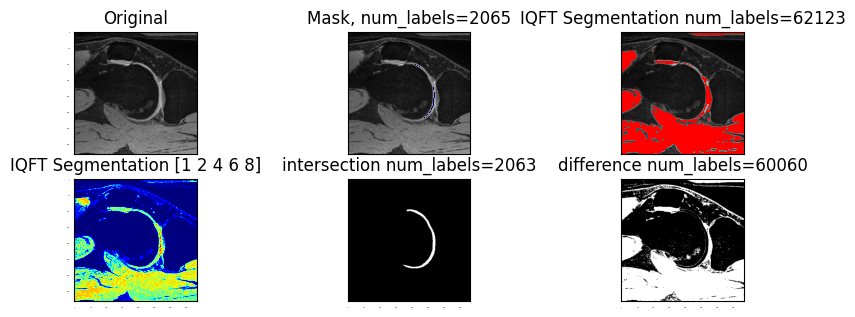

In [92]:
thetas = np.arange(0, 129*np.pi/64, np.pi/64)
#thetas = [43*np.pi/64]
DICE_SCORES = []
fig, ax = plt.subplots(nrows=2, ncols=2)

for q in range(3, 4):
    dice_scores = run_nii(img_file, cart_file, nqubits=q, thetas=thetas)     
    row = 0 if  q < 2 else 1
    col = (q-1) % 2
    ax[row, col].plot(dice_scores[:,0], dice_scores[:,1])
    DICE_SCORES.append(dice_scores)
#plt.show()

print(DICE_SCORES)
print(thetas)

## Determining Optimal &theta; Value ##

**Goal:** Determine the best &theta;-value for segmenting objects with the highest accuracy in a slice

**Work Flow:** 
1. Plot Dice Score vs. &theta;-value
2. Determine the max Dice Scorce and its &theta;-value
3. Try segmenting with a new &theta; range and determine if higher Dice Score can be retrieved.
4. Repeat steps 2 & 3 until accuracy plateaus.

Dice Scores:    [5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7728469512784253e-11, 5.7700527368781615e-11, 5.764472415082663e-11, 5.756122141183941e-11, 5.7312158434590915e-11, 5.717471920573885e-11, 5.676632835429246e-11, 0.0009451796404048277, 0.0018752930703168013, 0.0037313433389759695, 0.009242144232027514, 0.025454545507352214, 0.04561717357503189, 0.07207989583613404, 0.10976120657985955, 0.16842929890291067, 0.21680611134716768, 0.2674791533314058, 0.290

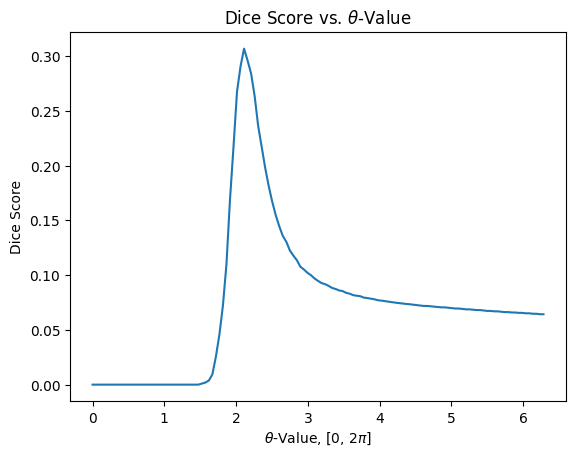

In [93]:
#print(DICE_SCORES)
from fractions import Fraction

dice = []
for i in range(0, len(thetas)):
    score = DICE_SCORES[0][i][1]
    dice.append(score)

print(f'Dice Scores:    {dice}')
print(f'Thetas:     {thetas}')

plt.plot(thetas, dice)
plt.xlabel(r'$\theta$-Value, [0, 2$\pi$]')
plt.ylabel(f'Dice Score')
plt.title(r'Dice Score vs. $\theta$-Value')

print(f'\n____________ Data Analysis ____________')
print(f'Max. Dice: {max(dice)}')
print(f'    Max. Dice Index: {dice.index(max(dice))}')
print(f'    Theta-Value (Dec): {thetas[dice.index(max(dice))]}')
print(f'    Theta-Value (Frac w/o pi): {Fraction(thetas[dice.index(max(dice))]/np.pi).limit_denominator(max_denominator=20)}')

## Classical Comparison ##

**Goal:** Perform segmentation on same slice, but with ... and ... algorithms. Use same Dice Score quantification to compare segmentation performance.

**Dice vs. mOUI:** Both method penalize for false postive foreground pixels. IoU is not differentiable, but is more strict and gives larger penalties for false positives.